In [17]:
# import opendatasets as od
# import os
# DATA_DIR = '../data/raw/vlsp'

# if not os.path.exists(DATA_DIR):
#   os.makedirs(DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/test-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/test-vi", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/val-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/val-vi", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/train-en", data_dir=DATA_DIR)
#   od.download("https://www.kaggle.com/datasets/nguyenanhtu164/train-vi", data_dir=DATA_DIR)

In [18]:
# !pip install pyvi --quiet

import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from pyvi import ViTokenizer

nltk.download('punkt')
nltk.download('punkt_tab')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

INPUT_PATHS = {
    "train": {
        "en": "../data/raw/vlsp/train-en/train.en.txt",
        "vi": "../data/raw/vlsp/train-vi/train.vi.txt"
    },
    "val": { 
        "en": "../data/raw/vlsp/val-en/val.en.new.txt",
        "vi": "../data/raw/vlsp/val-vi/val.vi.new.txt"
    },
    "test": { 
        "en": "../data/raw/vlsp/test-en/test.en.new.txt",
        "vi": "../data/raw/vlsp/test-vi/test.vi.new.txt"
    }
}

OUTPUT_DIR = "../data/med-ev"
os.makedirs(OUTPUT_DIR, exist_ok=True)

[nltk_data] Downloading package punkt to /home/rengumin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/rengumin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [19]:
def tokenize_en(text):
    return nltk.word_tokenize(str(text).strip().lower())

def tokenize_vi(text):
    text = str(text).strip().lower()
    text = ViTokenizer.tokenize(text)
    return text.split()

def build_vocab_from_tokens(token_lists, min_freq=2):
    counter = Counter()
    
    for tokens in token_lists:
        counter.update(tokens)
    
    vocab = {
        "<unk>": 0,
        "<pad>": 1,
        "<s>": 2,
        "</s>": 3
    }
    
    idx = 4
    for word, freq in counter.most_common():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
            
    return vocab

def save_json(data, filename):
    with open(f"{OUTPUT_DIR}/{filename}", "w", encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False)

In [20]:
all_train_en_tokens = []
all_train_vi_tokens = []

eda_stats = {'train': {}, 'val': {}, 'test': {}}

for split_name in ["train", "val", "test"]:
    print(f"\nProcessing {split_name}...")
    
    path_en = INPUT_PATHS[split_name]["en"]
    path_vi = INPUT_PATHS[split_name]["vi"]

    with open(path_en, 'r', encoding='utf-8') as f:
        raw_en = f.readlines()
    with open(path_vi, 'r', encoding='utf-8') as f:
        raw_vi = f.readlines()
        
    assert len(raw_en) == len(raw_vi), f"Lỗi ở tập {split_name}"

    lines_en_tokens = [tokenize_en(line) for line in raw_en]
    lines_vi_tokens = [tokenize_vi(line) for line in raw_vi]
    
    eda_stats[split_name]['en_len'] = [len(t) for t in lines_en_tokens]
    eda_stats[split_name]['vi_len'] = [len(t) for t in lines_vi_tokens]

    lines_en_str = [" ".join(tokens) for tokens in lines_en_tokens]
    lines_vi_str = [" ".join(tokens) for tokens in lines_vi_tokens]
    
    df = pd.DataFrame({'en': lines_en_str, 'vi': lines_vi_str})
    save_path = f"{OUTPUT_DIR}/{split_name}.csv"
    df.to_csv(save_path, index=False)
    
    if split_name == "train":
        all_train_en_tokens = lines_en_tokens
        all_train_vi_tokens = lines_vi_tokens


Processing train...

Processing val...

Processing test...


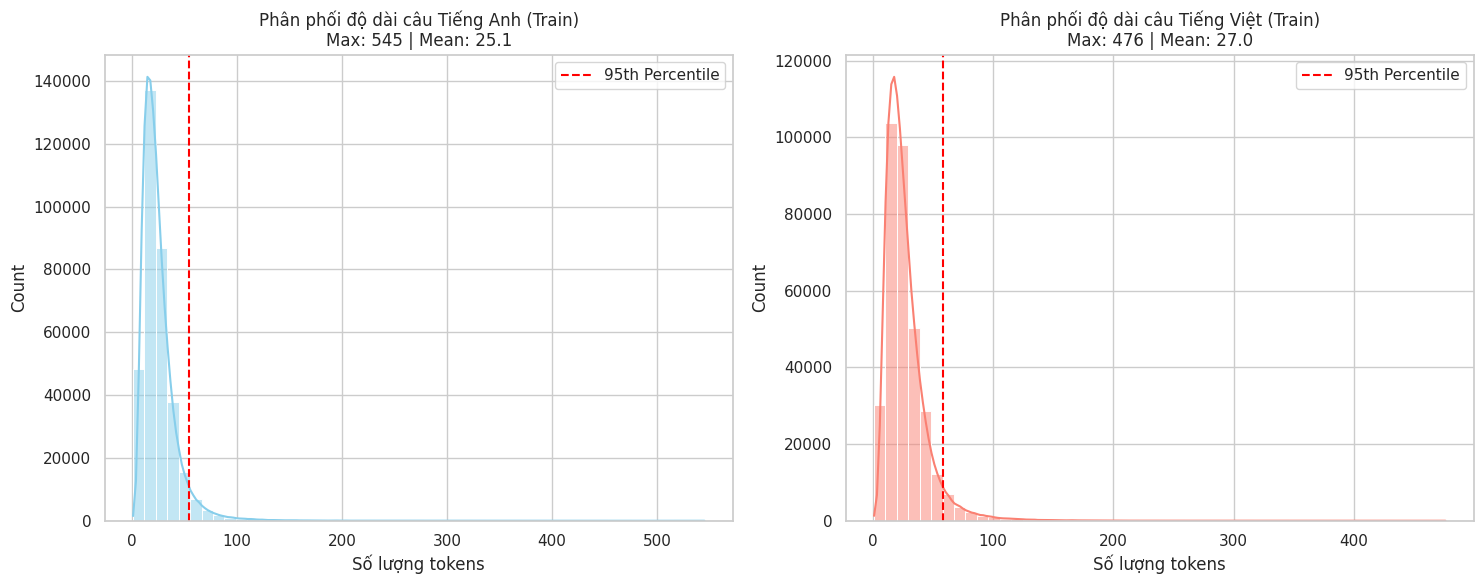

/tmp/ipykernel_1189807/210885390.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, ax=ax, palette=color)
/tmp/ipykernel_1189807/210885390.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, ax=ax, palette=color)


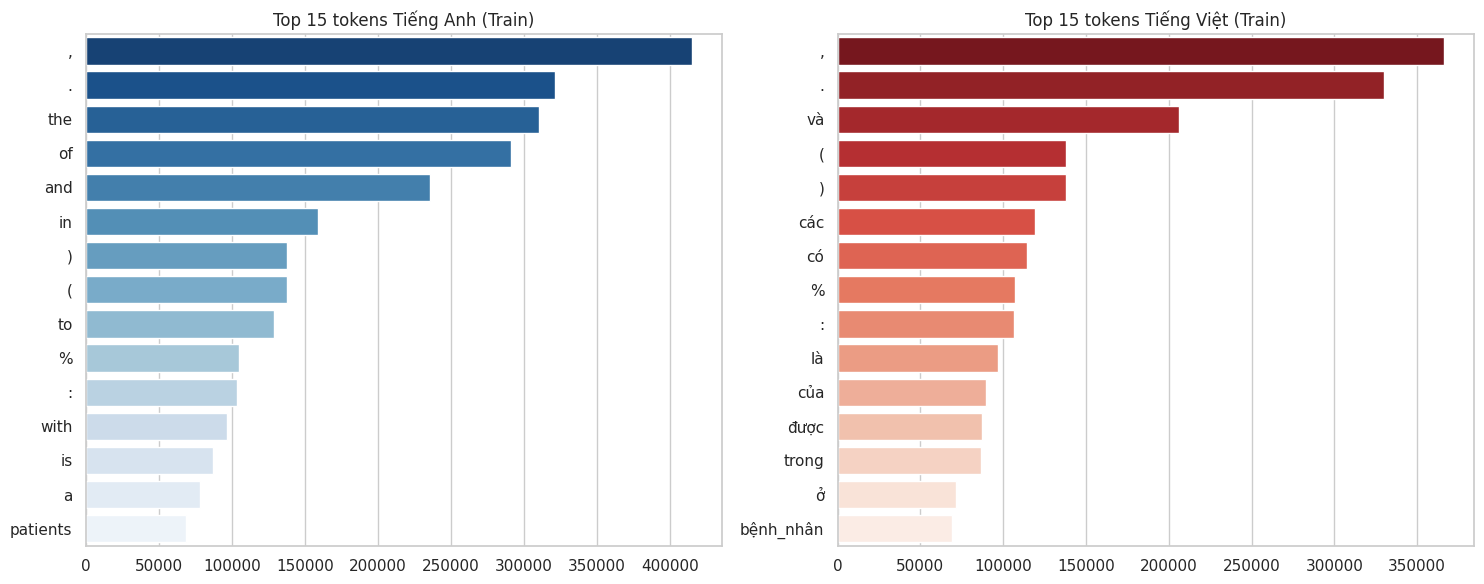

In [21]:
train_en_len = eda_stats['train']['en_len']
train_vi_len = eda_stats['train']['vi_len']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(train_en_len, bins=50, color='skyblue', kde=True, ax=axes[0])
axes[0].set_title(f"Phân phối độ dài câu Tiếng Anh (Train)\nMax: {max(train_en_len)} | Mean: {np.mean(train_en_len):.1f}")
axes[0].set_xlabel("Số lượng tokens")
axes[0].axvline(np.percentile(train_en_len, 95), color='red', linestyle='--', label='95th Percentile')
axes[0].legend()

sns.histplot(train_vi_len, bins=50, color='salmon', kde=True, ax=axes[1])
axes[1].set_title(f"Phân phối độ dài câu Tiếng Việt (Train)\nMax: {max(train_vi_len)} | Mean: {np.mean(train_vi_len):.1f}")
axes[1].set_xlabel("Số lượng tokens")
axes[1].axvline(np.percentile(train_vi_len, 95), color='red', linestyle='--', label='95th Percentile')
axes[1].legend()

plt.tight_layout()
plt.show()

def plot_top_words(tokens_list, title, ax, color):
    all_tokens = [t for sent in tokens_list for t in sent]
    counter = Counter(all_tokens)
    common = counter.most_common(15)
    words = [x[0] for x in common]
    counts = [x[1] for x in common]
    sns.barplot(x=counts, y=words, ax=ax, palette=color)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_top_words(all_train_en_tokens, "Top 15 tokens Tiếng Anh (Train)", axes[0], "Blues_r")
plot_top_words(all_train_vi_tokens, "Top 15 tokens Tiếng Việt (Train)", axes[1], "Reds_r")
plt.tight_layout()
plt.show()

In [22]:
en_vocab = build_vocab_from_tokens(all_train_en_tokens, min_freq=2)
vi_vocab = build_vocab_from_tokens(all_train_vi_tokens, min_freq=2)

en_id2token = {v: k for k, v in en_vocab.items()}
vi_id2token = {v: k for k, v in vi_vocab.items()}

save_json(en_vocab, "en_token2id.json")
save_json(vi_vocab, "vi_token2id.json")
save_json(en_id2token, "en_id2token.json")
save_json(vi_id2token, "vi_id2token.json")

print(f"EN: {len(en_vocab)}")
print(f"VI: {len(vi_vocab)}")

EN: 69025
VI: 45864
